# trainer test

### import module

In [6]:
pwd

'/home/anthonypark6904/simclr_module'

In [7]:
from model.test import AudioEncoder

In [8]:
import dm_pix
import jax.numpy as jnp
import jax
from flax import jax_utils
import wandb

from flax.training import common_utils
from utils.dataloader import mel_dataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np

In [9]:
data = mel_dataset('/home/anthonypark6904/dev_dataset', 'total')

Load song_meta.json...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707989/707989 [00:00<00:00, 782271.83it/s]


Load complete!

Load file list...


5it [00:00, 69.43it/s]


In [10]:
def contrastive_collate_batch(batch):
    x_train = [x for x, _ in batch]
    
    y_train = [y for _, y in batch]                  
    return np.stack(x_train + x_train, axis=0), np.array(y_train)

dataset_size = len(data)
train_size = int(dataset_size * 0.8)    
test_size = dataset_size - train_size

train_dataset, test_dataset, = random_split(data, [train_size, test_size])



train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, collate_fn=contrastive_collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=int(16/4), shuffle=True, num_workers=0, collate_fn=contrastive_collate_batch)

In [11]:
batch, _= next(iter(train_dataloader))

In [14]:
key = jax.random.PRNGKey(32)
params = AudioEncoder().init({'params':key,'dropout':key}, jnp.ones((32, 48, 1876, 1)))

tcmalloc: large alloc 1475346432 bytes == 0x6e9b0000 @  0x7fdf4415c680 0x7fdf4417d824 0x7fdf4417db8a 0x7fddf4742a8c 0x7fddefebeb35 0x7fddefec2acd 0x7fddefdfc2a9 0x7fddefbc57fd 0x7fddefbae781 0x5f6929 0x5f74f6 0x50c383 0x570b26 0x569dba 0x5f6eb3 0x5f8892 0x66931d 0x5f627e 0x56d2d5 0x569dba 0x5f6eb3 0x5f6082 0x56d2d5 0x569dba 0x5f6eb3 0x5f8892 0x66931d 0x5f627e 0x56d2d5 0x5f6cd6 0x56bbfa
tcmalloc: large alloc 1475354624 bytes == 0xc68b0000 @  0x7fdf4415c680 0x7fdf4417d824 0x7fddf0637045 0x7fddf06d8f46 0x7fddf06d9718 0x7fdf079c8096 0x7fddefec2acd 0x7fddefdfc2a9 0x7fddefbc57fd 0x7fddefbae781 0x5f6929 0x5f74f6 0x50c383 0x570b26 0x569dba 0x5f6eb3 0x5f8892 0x66931d 0x5f627e 0x56d2d5 0x569dba 0x5f6eb3 0x5f6082 0x56d2d5 0x569dba 0x5f6eb3 0x5f8892 0x66931d 0x5f627e 0x56d2d5 0x5f6cd6
tcmalloc: large alloc 1475346432 bytes == 0xc68b0000 @  0x7fdf4415c680 0x7fdf4417d824 0x7fdf4417db8a 0x7fddf4742a8c 0x7fddefebeb35 0x7fddefec2acd 0x7fddefdfc2a9 0x7fddefbc57fd 0x7fddefbae781 0x5f6929 0x5f74f6 0x50c38

In [16]:
batch = jnp.expand_dims(batch, axis=-1)

In [18]:
feats = AudioEncoder().apply(params, batch, rngs={'dropout':key})

In [19]:
feats.shape

(32, 512)

In [20]:
feats[:,None,:].shape

(32, 1, 512)

In [21]:
feats[None,:,:].shape

(1, 32, 512)

In [22]:
import optax

In [23]:
cos_sim = optax.cosine_similarity(feats[:,None,:], feats[None,:,:])
cos_sim.shape

(32, 32)

In [25]:
cos_sim

DeviceArray([[1.0000001 , 0.44243404, 0.47233137, ..., 0.42016616,
              0.48097083, 0.37079483],
             [0.44243404, 1.0000001 , 0.40733856, ..., 0.43011916,
              0.54239106, 0.57431173],
             [0.47233137, 0.40733856, 0.99999994, ..., 0.51305443,
              0.4810419 , 0.43335706],
             ...,
             [0.42016616, 0.43011916, 0.51305443, ..., 1.        ,
              0.38413945, 0.38568047],
             [0.48097083, 0.54239106, 0.4810419 , ..., 0.38413945,
              0.99999994, 0.5070113 ],
             [0.37079483, 0.57431173, 0.43335706, ..., 0.38568047,
              0.5070113 , 1.        ]], dtype=float32)

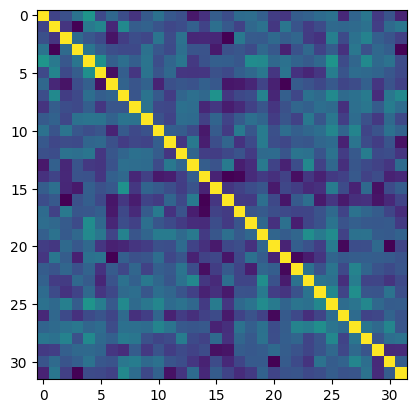

In [24]:
plt.imshow(cos_sim)

In [26]:
cos_sim /= 0.07
cos_sim

DeviceArray([[14.285716 ,  6.320486 ,  6.747591 , ...,  6.0023737,
               6.8710117,  5.297069 ],
             [ 6.320486 , 14.285716 ,  5.8191223, ...,  6.1445594,
               7.7484436,  8.204453 ],
             [ 6.747591 ,  5.8191223, 14.285713 , ...,  7.329349 ,
               6.8720274,  6.190815 ],
             ...,
             [ 6.0023737,  6.1445594,  7.329349 , ..., 14.285714 ,
               5.487706 ,  5.509721 ],
             [ 6.8710117,  7.7484436,  6.8720274, ...,  5.487706 ,
              14.285713 ,  7.2430186],
             [ 5.297069 ,  8.204453 ,  6.190815 , ...,  5.509721 ,
               7.2430186, 14.285714 ]], dtype=float32)

In [27]:
diag_range = jnp.arange(feats.shape[0], dtype=jnp.int32)
diag_range

DeviceArray([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
             15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
             30, 31], dtype=int32)

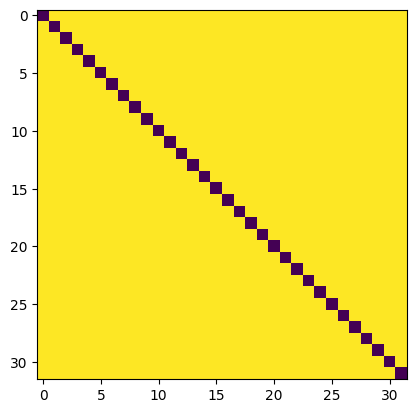

In [28]:
cos_sim = cos_sim.at[diag_range, diag_range].set(-9e15)
plt.imshow(cos_sim)

In [33]:
shifted_diag = jnp.roll(diag_range, batch.shape[0]//2)
print(diag_range)
print(shifted_diag)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  0  1  2  3  4  5  6  7
  8  9 10 11 12 13 14 15]


In [35]:
cos_sim[0,16]

DeviceArray(6.6657577, dtype=float32)

In [34]:
pos_logits = cos_sim[diag_range, shifted_diag]
pos_logits

DeviceArray([6.6657577, 6.2733374, 7.177351 , 7.648434 , 7.6527033,
             8.131986 , 7.176394 , 8.003541 , 7.9154663, 8.251413 ,
             7.538574 , 8.145046 , 8.483728 , 6.2777233, 5.2481804,
             7.18519  , 6.6657577, 6.2733374, 7.177351 , 7.648434 ,
             7.6527033, 8.131986 , 7.176394 , 8.003541 , 7.9154663,
             8.251413 , 7.538574 , 8.145046 , 8.483728 , 6.2777233,
             5.2481804, 7.18519  ], dtype=float32)

In [37]:
cos_sim.shape

(32, 32)

In [36]:
jax.nn.logsumexp(cos_sim, axis=-1)

DeviceArray([10.890387 , 11.00034  , 10.751769 , 10.651169 , 11.620351 ,
             10.95671  , 10.127899 , 11.3607025, 10.706646 , 10.907665 ,
             11.015344 , 10.545628 , 10.836529 , 10.762903 ,  9.690686 ,
             10.604003 , 10.103782 , 10.49164  , 10.693768 , 11.434811 ,
             10.25871  , 10.500273 , 10.682018 , 11.033133 , 10.924193 ,
             11.680485 , 10.18227  , 11.402122 , 11.225077 , 10.3362875,
             10.837867 , 10.550934 ], dtype=float32)

In [38]:
nll = - pos_logits + jax.nn.logsumexp(cos_sim, axis=-1)
nll.mean()

DeviceArray(3.413014, dtype=float32)

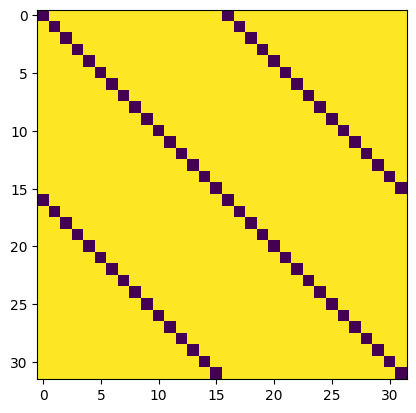

In [42]:
plt.imshow(cos_sim.at[shifted_diag, diag_range].set(-9e15))

In [43]:
pos_logits[:,None].shape

(32, 1)

In [44]:
comb_sim = jnp.concatenate([pos_logits[:,None],
                            cos_sim.at[shifted_diag, diag_range].set(-9e15)],
                           axis=-1)

## plt.imshow(comb_sim)


In [50]:
sim_argsort =(-comb_sim).argsort(axis=-1).argmin(axis=-1)

In [56]:
sim_argsort

DeviceArray([20, 24, 11,  8, 15,  4,  6,  8,  5,  1, 10,  2,  0, 20, 24,
              7,  8, 22,  9, 14,  4,  1, 12,  7,  5, 10,  4,  7,  3, 20,
             29,  9], dtype=int32)

In [58]:
(sim_argsort + 1)

DeviceArray([21, 25, 12,  9, 16,  5,  7,  9,  6,  2, 11,  3,  1, 21, 25,
              8,  9, 23, 10, 15,  5,  2, 13,  8,  6, 11,  5,  8,  4, 21,
             30, 10], dtype=int32)

In [ ]:
cos_sim = optax.cosine_similarity(feats[:,None,:], feats[None,:,:])
cos_sim /= self.temperature
diag_range = jnp.arange(feats.shape[0], dtype=jnp.int32)
cos_sim = cos_sim.at[diag_range, diag_range].set(-9e15)

shifted_diag = jnp.roll(diag_range, x.shape[0]//2)
pos_logits = cos_sim[diag_range, shifted_diag]

# InfoNCE loss
nll = - pos_logits + nn.logsumexp(cos_sim, axis=-1)
nll = nll.mean()

# Logging
metrics = {'loss': nll}
# Determine ranking position of positive example
comb_sim = jnp.concatenate([pos_logits[:,None],
                            cos_sim.at[shifted_diag, diag_range].set(-9e15)],
                           axis=-1)
sim_argsort = (-comb_sim).argsort(axis=-1).argmin(axis=-1)

# Logging of ranking position
metrics['acc_top1'] = (sim_argsort == 0).mean()
metrics['acc_top5'] = (sim_argsort < 5).mean()
metrics['acc_mean_pos'] = (sim_argsort + 1).mean()

In [7]:
trainer = AudioEncoderTrainer(exmp=jnp.ones((16, 48, 1876,1)))

In [24]:
len(batch)

8

In [10]:
AudioEncoder().init(key)(batch)

NameError: name 'key' is not defined

In [5]:
trainer.train_model(train_dataloader, test_dataloader, num_epochs=3)

Epoch 1:   0%|                                                                                                                                                                              | 0/87 [00:00<?, ?it/s]tcmalloc: large alloc 5538316288 bytes == 0x82e3a000 @  0x7fcd19668680 0x7fcd19689824 0x7fcd19689b8a 0x7fcbca70ea8c 0x7fcbc5e8ab35 0x7fcbc5e8eacd 0x7fcbc5dc9795 0x7fcbc5b91e2a 0x7fcbc5b7a781 0x5f6929 0x5f74f6 0x50c383 0x570b26 0x569dba 0x5f6eb3 0x5f6082 0x56d2d5 0x569dba 0x5f6eb3 0x59d81e 0x5f627e 0x56d2d5 0x569dba 0x5f6eb3 0x5f6082 0x56d2d5 0x5f6cd6 0x56bbfa 0x5f6cd6 0x56bbfa 0x569dba
tcmalloc: large alloc 3319922688 bytes == 0x22af72000 @  0x7fcd19668680 0x7fcd19689824 0x7fcbc6603045 0x7fcbc6619441 0x7fcbc661a3b0 0x7fcbc661adab 0x7fcbc66a3adb 0x7fcbc66a4f59 0x7fcbc66a5718 0x7fcc1b86e394 (nil)
Epoch 1:   1%|█▉                                                                                                                                                                    | 1/87 

{'acc_mean_pos': array(2.5, dtype=float32), 'acc_top1': array(0., dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(2.4876919, dtype=float32)}


tcmalloc: large alloc 5538316288 bytes == 0x82e3a000 @  0x7fcd19668680 0x7fcd19689824 0x7fcd19689b8a 0x7fcbca70ea8c 0x7fcbc5e8ab35 0x7fcbc5e8eacd 0x7fcbc5c0653f 0x7fcbc5c0827d 0x5f74f6 0x571164 0x569dba 0x50bca0 0x56cc1f 0x569dba 0x50bca0 0x56cc1f 0x569dba 0x6902a7 0x6023c4 0x5c6730 0x56bacd 0x501488 0x56d4d6 0x501488 0x56d4d6 0x501488 0x505166 0x56bbfa 0x5f6cd6 0x56bacd 0x5f6cd6
tcmalloc: large alloc 3319922688 bytes == 0x22af72000 @  0x7fcd19668680 0x7fcd19689824 0x7fcbc6603045 0x7fcbc6619441 0x7fcbc661a3b0 0x7fcbc661adab 0x7fcbc66a3adb 0x7fcbc66a4f59 0x7fcbc66a5718 0x7fcc1b86e394 (nil)
Epoch 1:   2%|███▊                                                                                                                                                                  | 2/87 [00:28<18:22, 12.97s/it]

{'acc_mean_pos': array(2.5, dtype=float32), 'acc_top1': array(0., dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.6713549, dtype=float32)}


tcmalloc: large alloc 5538316288 bytes == 0x82e3a000 @  0x7fcd19668680 0x7fcd19689824 0x7fcd19689b8a 0x7fcbca70ea8c 0x7fcbc5e8ab35 0x7fcbc5e8eacd 0x7fcbc5c0653f 0x7fcbc5c0827d 0x5f74f6 0x571164 0x569dba 0x50bca0 0x56cc1f 0x569dba 0x50bca0 0x56cc1f 0x569dba 0x6902a7 0x6023c4 0x5c6730 0x56bacd 0x501488 0x56d4d6 0x501488 0x56d4d6 0x501488 0x505166 0x56bbfa 0x5f6cd6 0x56bacd 0x5f6cd6
tcmalloc: large alloc 3319922688 bytes == 0x22af72000 @  0x7fcd19668680 0x7fcd19689824 0x7fcbc6603045 0x7fcbc6619441 0x7fcbc661a3b0 0x7fcbc661adab 0x7fcbc66a3adb 0x7fcbc66a4f59 0x7fcbc66a5718 0x7fcc1b86e394 (nil)
Epoch 1:   3%|█████▋                                                                                                                                                                | 3/87 [00:35<14:55, 10.66s/it]

{'acc_mean_pos': array(2., dtype=float32), 'acc_top1': array(0.25, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.2609322, dtype=float32)}


tcmalloc: large alloc 5538316288 bytes == 0x82e3a000 @  0x7fcd19668680 0x7fcd19689824 0x7fcd19689b8a 0x7fcbca70ea8c 0x7fcbc5e8ab35 0x7fcbc5e8eacd 0x7fcbc5c0653f 0x7fcbc5c0827d 0x5f74f6 0x571164 0x569dba 0x50bca0 0x56cc1f 0x569dba 0x50bca0 0x56cc1f 0x569dba 0x6902a7 0x6023c4 0x5c6730 0x56bacd 0x501488 0x56d4d6 0x501488 0x56d4d6 0x501488 0x505166 0x56bbfa 0x5f6cd6 0x56bacd 0x5f6cd6
tcmalloc: large alloc 3319922688 bytes == 0x22af72000 @  0x7fcd19668680 0x7fcd19689824 0x7fcbc6603045 0x7fcbc6619441 0x7fcbc661a3b0 0x7fcbc661adab 0x7fcbc66a3adb 0x7fcbc66a4f59 0x7fcbc66a5718 0x7fcc1b86e394 (nil)
Epoch 1:   5%|███████▋                                                                                                                                                              | 4/87 [00:43<13:14,  9.57s/it]

{'acc_mean_pos': array(2.25, dtype=float32), 'acc_top1': array(0.25, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.3677652, dtype=float32)}


tcmalloc: large alloc 5538316288 bytes == 0x82e3a000 @  0x7fcd19668680 0x7fcd19689824 0x7fcd19689b8a 0x7fcbca70ea8c 0x7fcbc5e8ab35 0x7fcbc5e8eacd 0x7fcbc5c0653f 0x7fcbc5c0827d 0x5f74f6 0x571164 0x569dba 0x50bca0 0x56cc1f 0x569dba 0x50bca0 0x56cc1f 0x569dba 0x6902a7 0x6023c4 0x5c6730 0x56bacd 0x501488 0x56d4d6 0x501488 0x56d4d6 0x501488 0x505166 0x56bbfa 0x5f6cd6 0x56bacd 0x5f6cd6
tcmalloc: large alloc 3319922688 bytes == 0x22af72000 @  0x7fcd19668680 0x7fcd19689824 0x7fcbc6603045 0x7fcbc6619441 0x7fcbc661a3b0 0x7fcbc661adab 0x7fcbc66a3adb 0x7fcbc66a4f59 0x7fcbc66a5718 0x7fcc1b86e394 (nil)
Epoch 1:   6%|█████████▌                                                                                                                                                            | 5/87 [00:53<12:54,  9.44s/it]

{'acc_mean_pos': array(1., dtype=float32), 'acc_top1': array(1., dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(0.24804997, dtype=float32)}


tcmalloc: large alloc 5538316288 bytes == 0x82e3a000 @  0x7fcd19668680 0x7fcd19689824 0x7fcd19689b8a 0x7fcbca70ea8c 0x7fcbc5e8ab35 0x7fcbc5e8eacd 0x7fcbc5c0653f 0x7fcbc5c0827d 0x5f74f6 0x571164 0x569dba 0x50bca0 0x56cc1f 0x569dba 0x50bca0 0x56cc1f 0x569dba 0x6902a7 0x6023c4 0x5c6730 0x56bacd 0x501488 0x56d4d6 0x501488 0x56d4d6 0x501488 0x505166 0x56bbfa 0x5f6cd6 0x56bacd 0x5f6cd6
Epoch 1:   7%|███████████▍                                                                                                                                                          | 6/87 [01:00<11:48,  8.75s/it]

{'acc_mean_pos': array(2.25, dtype=float32), 'acc_top1': array(0., dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.6862497, dtype=float32)}


tcmalloc: large alloc 5538316288 bytes == 0x82e3a000 @  0x7fcd19668680 0x7fcd19689824 0x7fcd19689b8a 0x7fcbca70ea8c 0x7fcbc5e8ab35 0x7fcbc5e8eacd 0x7fcbc5c0653f 0x7fcbc5c0827d 0x5f74f6 0x571164 0x569dba 0x50bca0 0x56cc1f 0x569dba 0x50bca0 0x56cc1f 0x569dba 0x6902a7 0x6023c4 0x5c6730 0x56bacd 0x501488 0x56d4d6 0x501488 0x56d4d6 0x501488 0x505166 0x56bbfa 0x5f6cd6 0x56bacd 0x5f6cd6
Epoch 1:   8%|█████████████▎                                                                                                                                                        | 7/87 [01:07<11:01,  8.27s/it]

{'acc_mean_pos': array(1.75, dtype=float32), 'acc_top1': array(0.5, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.3195832, dtype=float32)}


tcmalloc: large alloc 5538316288 bytes == 0x82e3a000 @  0x7fcd19668680 0x7fcd19689824 0x7fcd19689b8a 0x7fcbca70ea8c 0x7fcbc5e8ab35 0x7fcbc5e8eacd 0x7fcbc5c0653f 0x7fcbc5c0827d 0x5f74f6 0x571164 0x569dba 0x50bca0 0x56cc1f 0x569dba 0x50bca0 0x56cc1f 0x569dba 0x6902a7 0x6023c4 0x5c6730 0x56bacd 0x501488 0x56d4d6 0x501488 0x56d4d6 0x501488 0x505166 0x56bbfa 0x5f6cd6 0x56bacd 0x5f6cd6
Epoch 1:   9%|███████████████▎                                                                                                                                                      | 8/87 [01:15<10:30,  7.98s/it]

{'acc_mean_pos': array(2., dtype=float32), 'acc_top1': array(0.25, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.4165246, dtype=float32)}


tcmalloc: large alloc 5538316288 bytes == 0x82e3a000 @  0x7fcd19668680 0x7fcd19689824 0x7fcd19689b8a 0x7fcbca70ea8c 0x7fcbc5e8ab35 0x7fcbc5e8eacd 0x7fcbc5c0653f 0x7fcbc5c0827d 0x5f74f6 0x571164 0x569dba 0x50bca0 0x56cc1f 0x569dba 0x50bca0 0x56cc1f 0x569dba 0x6902a7 0x6023c4 0x5c6730 0x56bacd 0x501488 0x56d4d6 0x501488 0x56d4d6 0x501488 0x505166 0x56bbfa 0x5f6cd6 0x56bacd 0x5f6cd6
Epoch 1:  10%|█████████████████▏                                                                                                                                                    | 9/87 [01:22<10:12,  7.85s/it]

{'acc_mean_pos': array(1.75, dtype=float32), 'acc_top1': array(0.5, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.1524405, dtype=float32)}


Epoch 1:  11%|██████████████████▉                                                                                                                                                  | 10/87 [01:30<10:00,  7.80s/it]

{'acc_mean_pos': array(2., dtype=float32), 'acc_top1': array(0.25, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(0.99006104, dtype=float32)}


Epoch 1:  13%|████████████████████▊                                                                                                                                                | 11/87 [01:37<09:43,  7.68s/it]

{'acc_mean_pos': array(1.75, dtype=float32), 'acc_top1': array(0.5, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(0.899086, dtype=float32)}


Epoch 1:  14%|██████████████████████▊                                                                                                                                              | 12/87 [01:45<09:32,  7.63s/it]

{'acc_mean_pos': array(2.25, dtype=float32), 'acc_top1': array(0.25, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.5436885, dtype=float32)}


Epoch 1:  15%|████████████████████████▋                                                                                                                                            | 13/87 [01:52<09:19,  7.56s/it]

{'acc_mean_pos': array(1.75, dtype=float32), 'acc_top1': array(0.5, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.6181979, dtype=float32)}


Epoch 1:  16%|██████████████████████████▌                                                                                                                                          | 14/87 [02:00<09:09,  7.52s/it]

{'acc_mean_pos': array(2., dtype=float32), 'acc_top1': array(0.25, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.4416885, dtype=float32)}


Epoch 1:  17%|████████████████████████████▍                                                                                                                                        | 15/87 [02:07<09:01,  7.52s/it]

{'acc_mean_pos': array(1.25, dtype=float32), 'acc_top1': array(0.75, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(0.60070944, dtype=float32)}


Epoch 1:  18%|██████████████████████████████▎                                                                                                                                      | 16/87 [02:14<08:50,  7.47s/it]

{'acc_mean_pos': array(1.75, dtype=float32), 'acc_top1': array(0.5, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.1379066, dtype=float32)}


Epoch 1:  20%|████████████████████████████████▏                                                                                                                                    | 17/87 [02:22<08:42,  7.47s/it]

{'acc_mean_pos': array(2., dtype=float32), 'acc_top1': array(0.25, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.3539827, dtype=float32)}


Epoch 1:  21%|██████████████████████████████████▏                                                                                                                                  | 18/87 [02:29<08:33,  7.44s/it]

{'acc_mean_pos': array(2.5, dtype=float32), 'acc_top1': array(0.25, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.3273382, dtype=float32)}


Epoch 1:  22%|████████████████████████████████████                                                                                                                                 | 19/87 [02:37<08:25,  7.44s/it]

{'acc_mean_pos': array(1.75, dtype=float32), 'acc_top1': array(0.25, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.42888, dtype=float32)}


Epoch 1:  23%|█████████████████████████████████████▉                                                                                                                               | 20/87 [02:44<08:19,  7.45s/it]

{'acc_mean_pos': array(1.25, dtype=float32), 'acc_top1': array(0.75, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(0.8209779, dtype=float32)}


Epoch 1:  24%|███████████████████████████████████████▊                                                                                                                             | 21/87 [02:52<08:11,  7.45s/it]

{'acc_mean_pos': array(1.75, dtype=float32), 'acc_top1': array(0.5, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.1168487, dtype=float32)}


Epoch 1:  25%|█████████████████████████████████████████▋                                                                                                                           | 22/87 [02:59<08:04,  7.45s/it]

{'acc_mean_pos': array(2., dtype=float32), 'acc_top1': array(0.25, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.2187393, dtype=float32)}


Epoch 1:  26%|███████████████████████████████████████████▌                                                                                                                         | 23/87 [03:06<07:54,  7.41s/it]

{'acc_mean_pos': array(2., dtype=float32), 'acc_top1': array(0.25, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.2106903, dtype=float32)}


Epoch 1:  28%|█████████████████████████████████████████████▌                                                                                                                       | 24/87 [03:14<07:45,  7.39s/it]

{'acc_mean_pos': array(2.5, dtype=float32), 'acc_top1': array(0., dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.7335165, dtype=float32)}


Epoch 1:  29%|███████████████████████████████████████████████▍                                                                                                                     | 25/87 [03:21<07:39,  7.41s/it]

{'acc_mean_pos': array(1.25, dtype=float32), 'acc_top1': array(0.75, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(0.9045358, dtype=float32)}


Epoch 1:  30%|█████████████████████████████████████████████████▎                                                                                                                   | 26/87 [03:28<07:28,  7.36s/it]

{'acc_mean_pos': array(2.25, dtype=float32), 'acc_top1': array(0.25, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.2032773, dtype=float32)}


Epoch 1:  31%|███████████████████████████████████████████████████▏                                                                                                                 | 27/87 [03:36<07:22,  7.37s/it]

{'acc_mean_pos': array(2., dtype=float32), 'acc_top1': array(0.25, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.1785383, dtype=float32)}


Epoch 1:  32%|█████████████████████████████████████████████████████                                                                                                                | 28/87 [03:43<07:14,  7.36s/it]

{'acc_mean_pos': array(2., dtype=float32), 'acc_top1': array(0.5, dtype=float32), 'acc_top5': array(1., dtype=float32), 'loss': array(1.0742671, dtype=float32)}


KeyboardInterrupt: 